<font size="5">**Project Summary**</font><br><br>
In this competition, the main task is to do surface classification given robot sensors' time series data. 

After reviewing the notebook, the champion of this competition is to use fourier analysis [https://www.kaggle.com/trohwer64/simple-fourier-analysis](http://). Other solutions evolve classical machine learning algorithms, e.g Random Forest, Decision Trees... They have achieved good performance. 

Traditionally time series classification includes Fourier Transform or feature engineering. Although they can perform well in small datasets, they are heuristic and not task dependent. Traditional machine learning skills may not have the same representation power compared to deep learning. In this project, I mainly explore ways to solve the problem by using deep learning. After searching papers at [https://scholar.google.com/](http://) I found that 1d convolution neural network**[1][2]** is a good technique when doing the time series classification job. So I apply 1d convolutional neural network to solve this problem. The core code is based on pytorch. 



Reference Papers:<br>
*[1] Yi Zheng, Qi Liu, Enhong Chen, Yong Ge, J. Leon Zhao, Time Series Classification Using Multi-Channels Deep Convolutional Neural Networks, IJCAI 2015<br>
[2] Jian Bo Yang, Minh Nhut Nguyen, Phyo Phyo San, Xiao Li Li, Shonali Krishnaswamy, Deep Convolutional Neural Networks On Multichannel Time Series
For Human Activity Recognition, IJCAI 2015<br>*

<font size="5">**External libs I use**</font><br>

In [90]:
# libs I am using
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [91]:
# EDA
y = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')
train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
test = pd.read_csv('/kaggle/input/career-con-2019/X_test.csv')
sub = pd.read_csv('/kaggle/input/career-con-2019/sample_submission.csv')
print('traning data shape')
print(train.shape)
print('testing data shape')
print(test.shape)

traning data shape
(487680, 13)
testing data shape
(488448, 13)


<font size="5">**EDA**</font><br>

In [92]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [93]:
train['series_id'].nunique(), test['series_id'].nunique()

(3810, 3816)

In [94]:
y['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [95]:
y['group_id'].nunique()

73

In [96]:
y['surface'].value_counts().reset_index().rename(columns={'index': 'target'})

,target,surface
0,concrete,779
1,soft_pvc,732
2,wood,607
3,tiled,514
4,fine_concrete,363
5,hard_tiles_large_space,308
6,soft_tiles,297
7,carpet,189
8,hard_tiles,21


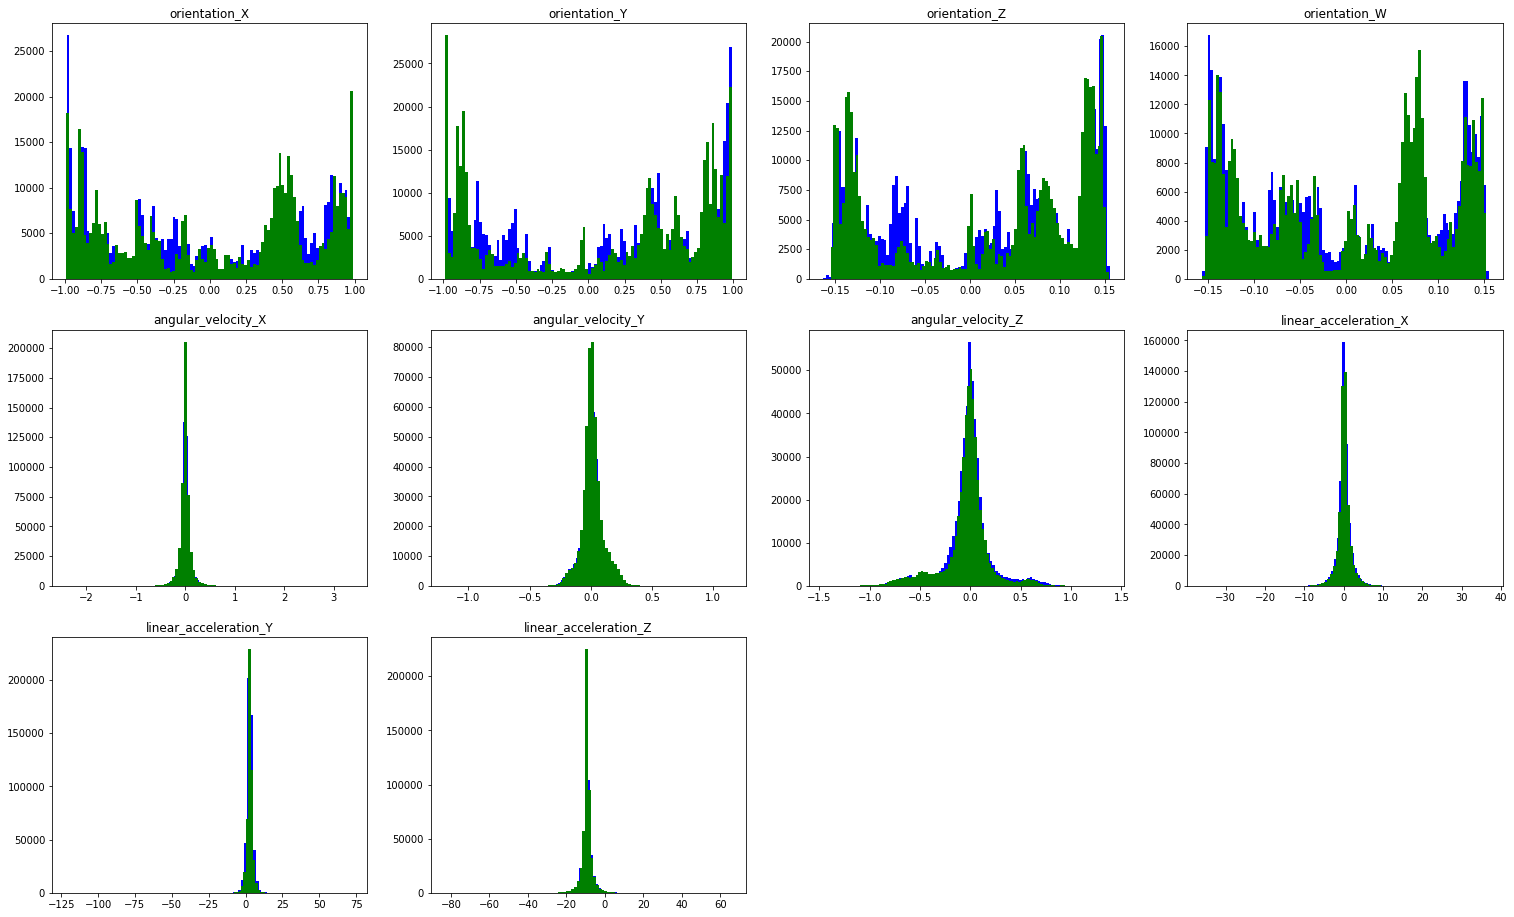

In [97]:
# data distribution for all features in training and testing data
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], color='blue', bins=100)
    plt.hist(test[col], color='green', bins=100)
    plt.title(col)

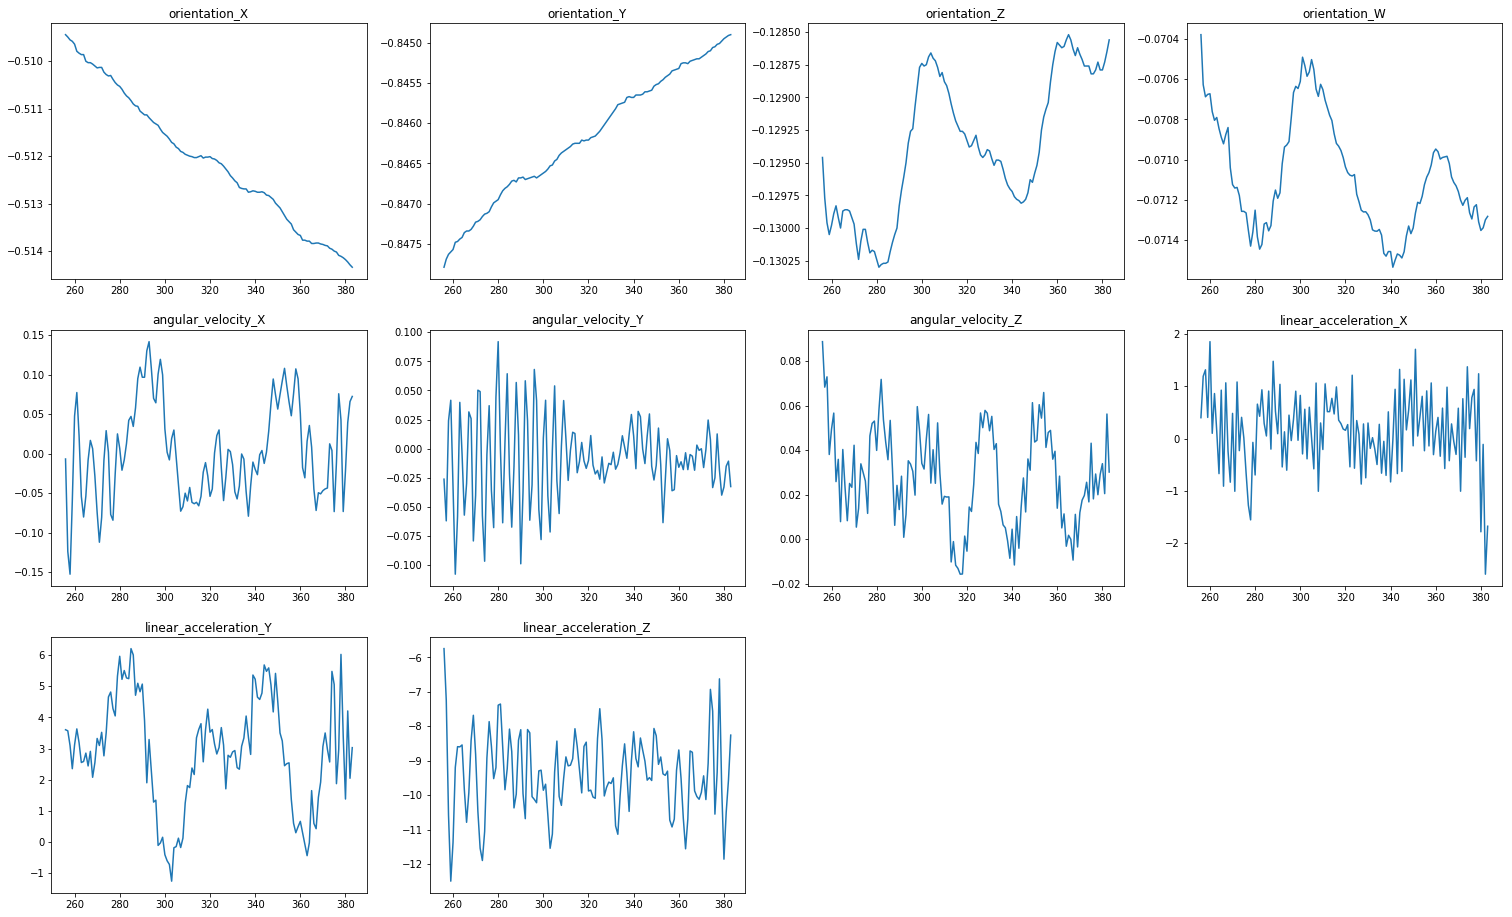

In [98]:
#data in one time series
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 2, col])
    plt.title(col)

<font size="5">**Dataset and Data Preprocessing**</font><br>

<font size="3">**Original data**</font><br>
For dataset, the original data includes 7816 different time series(First 3810 samples are training data with labels, following 3816 are testing data without labels). 

<font size="3">**New dataset**</font><br>
Since the professor said there may have some bugs in Kaggle's grading system. We only use **original training data** right now.

<font size="3">**Testing accuracy**</font><br>
Now the total dataset size is 3810. Given the script in slack, we use last 20 samples as testing data and rest 3790 samples as training data. 
<font size="3">**Cross-validation**</font><br>
I personally think only the given 20 testing data is too small and may make the result not as robust as cross-validation. So I also do cross-validation step to make our model more robust. I split the raw training data into training data, validation data, testing data by the size of 2286, 762, 762.

<font size="3">**Testing accuracy**</font><br>
Compared with other methods which firstly prepross data using fourier transformation. I just unify data between 0 and 1 and feed this simply preprocessed data into the neural network. The superising result is that those two methods have similar performance when doing cross validation if feeding different proprecessed data into the same network architecture. This phenomenon seems to tell us that if the neural network is strong enough, it can automatically catch important features in the data.

In order to make it easier for pytorch to process data, I convert Numpy arrays into `torch.tensor` objects of proper type (float for samples, and long - for targets).


In [99]:
# this function is used to preprocess data. It simply transforms 4D orientation to 3D angle form.
def preprocess_data():
    X_train = pd.read_csv('../input/career-con-2019/X_train.csv')
    y_train = pd.read_csv('../input/career-con-2019/y_train.csv')
    X_train = pd.merge(X_train,y_train,on='series_id')
    print("preprocessing data")
    labelencoder = LabelEncoder()
    X_train['surface'] = labelencoder.fit_transform(X_train['surface'])

    def q_to_angle(q_val):
        #We assume q_val is in this format: [qw, q1, q2, q3]
        #And the quaternion is normalized
        roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
        pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
        yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
        return np.array([roll, pitch, yaw])
    
    quat_arr = np.array(X_train[['orientation_W','orientation_X','orientation_Y','orientation_Z']])
    euler_arr = np.zeros([quat_arr.shape[0],3])
    
    for n,arr in enumerate(quat_arr):
        euler_arr[n] = q_to_angle(arr)
    X_train['roll'] = euler_arr[:,0]
    X_train['pitch'] = euler_arr[:,1]
    X_train['yaw'] = euler_arr[:,2]

    num_meas = 128
    num_series = X_train['series_id'].nunique()

    cols = list(X_train.columns.values)
    cols.remove('group_id')
    cols.append('group_id')
    cols.remove('surface')
    cols.append('surface')
    X_train = X_train[cols]

    feat_cols = ['roll','pitch','yaw','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']
    feat_array = np.array(X_train[feat_cols])
    feat_array = np.reshape(feat_array,[num_series,128,len(feat_cols)])

    target_array = np.array(X_train['surface'])
    target_array = np.reshape(target_array,[num_series,128])
    target_array = target_array[:,0]
    
    return feat_array, target_array

raw_array, target_array = preprocess_data()

preprocessing data


In [100]:
# I use this functin to split data into three parts, traning data, validation data and testing data.
# This function also reads 9 channels of data for further input of neural network 
def create_datasets(data_arr, train_size, valid_pct=0.2, seed=None):
    
    raw =  data_arr
    sz = train_size

    idx = np.arange(sz)
    trn_idx, tst_idx = train_test_split(idx, test_size=0.2, random_state=1)
    trn_idx, val_idx = train_test_split(trn_idx, test_size=0.25, random_state=1)
    
    
    trn_ds = TensorDataset(
        torch.tensor(raw[0][:sz][trn_idx]).float(),
        torch.tensor(raw[1][:sz][trn_idx]).float(),
        torch.tensor(raw[2][:sz][trn_idx]).float(),
        torch.tensor(raw[3][:sz][trn_idx]).float(),
        torch.tensor(raw[4][:sz][trn_idx]).float(),
        torch.tensor(raw[5][:sz][trn_idx]).float(),
        torch.tensor(raw[6][:sz][trn_idx]).float(),
        torch.tensor(raw[7][:sz][trn_idx]).float(),
        torch.tensor(raw[8][:sz][trn_idx]).float(),
        torch.tensor(target[:sz][trn_idx]).long())
    
    val_ds = TensorDataset(
        torch.tensor(raw[0][:sz][val_idx]).float(),
        torch.tensor(raw[1][:sz][val_idx]).float(), 
        torch.tensor(raw[2][:sz][val_idx]).float(), 
        torch.tensor(raw[3][:sz][val_idx]).float(), 
        torch.tensor(raw[4][:sz][val_idx]).float(), 
        torch.tensor(raw[5][:sz][val_idx]).float(), 
        torch.tensor(raw[6][:sz][val_idx]).float(), 
        torch.tensor(raw[7][:sz][val_idx]).float(), 
        torch.tensor(raw[8][:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    
    tst_ds = TensorDataset(
        torch.tensor(raw[0][:sz][tst_idx]).float(),
        torch.tensor(raw[1][:sz][tst_idx]).float(),
        torch.tensor(raw[2][:sz][tst_idx]).float(),
        torch.tensor(raw[3][:sz][tst_idx]).float(),
        torch.tensor(raw[4][:sz][tst_idx]).float(),
        torch.tensor(raw[5][:sz][tst_idx]).float(),
        torch.tensor(raw[6][:sz][tst_idx]).float(),
        torch.tensor(raw[7][:sz][tst_idx]).float(),
        torch.tensor(raw[8][:sz][tst_idx]).float(),
        torch.tensor(target[:sz][tst_idx]).long())
    
    new_tst_ds = TensorDataset(
        torch.tensor(raw[0][:sz][sz-20:sz]).float(),
        torch.tensor(raw[1][:sz][sz-20:sz]).float(),
        torch.tensor(raw[2][:sz][sz-20:sz]).float(),
        torch.tensor(raw[3][:sz][sz-20:sz]).float(),
        torch.tensor(raw[4][:sz][sz-20:sz]).float(),
        torch.tensor(raw[5][:sz][sz-20:sz]).float(),
        torch.tensor(raw[6][:sz][sz-20:sz]).float(),
        torch.tensor(raw[7][:sz][sz-20:sz]).float(),
        torch.tensor(raw[8][:sz][sz-20:sz]).float(),
        torch.tensor(target[:sz][sz-20:sz]).long())
    
    return trn_ds, val_ds, tst_ds, new_tst_ds

# dataloader to transfer numpy to pytorch tensor data type
def create_loaders(data, bs=128, jobs=0):
    
    trn_ds, val_ds, tst_ds, new_tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    new_tst_dl = DataLoader(new_tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    
    return trn_dl, val_dl, tst_dl, new_tst_dl



<font size="5">**Network Architecture**</font><br>

I have do several experiments of different architectures, the results are:

**2 layer Multi-channel CNN kernel1=16, kernel2=11: 0.8<br>**
2 layer Multi-channel CNN kernel1=5 kernel2=5: 0.7<br>
2 layer Multi-channel CNN kernel1=16 kernel2=5: 0.76<br>
3 layer Multi-channel CNN kernel_size=16 kernel_size=11 kernel_size=8: 0.77<br>
4 layer Multi-channel CNN kernel_size=16 kernel_size=11 kernel_size=8kernel_size=5: 0.6<br>
1d CNN tanh: 0.6<br>
1d CNN ReLU/Softmax(last layer)/Dropout: 0.75<br>
1d CNN ReLU/Batch Normalization/Dropout: 0.7<br>
1d CNN PReLU/Batch Normalization/Dropout: 0.75<br>

I choose the best performed architecture: 2 layer multi-channel CNN with kernel1=16, kernel2-11 and achieve accuarcy of 0.8

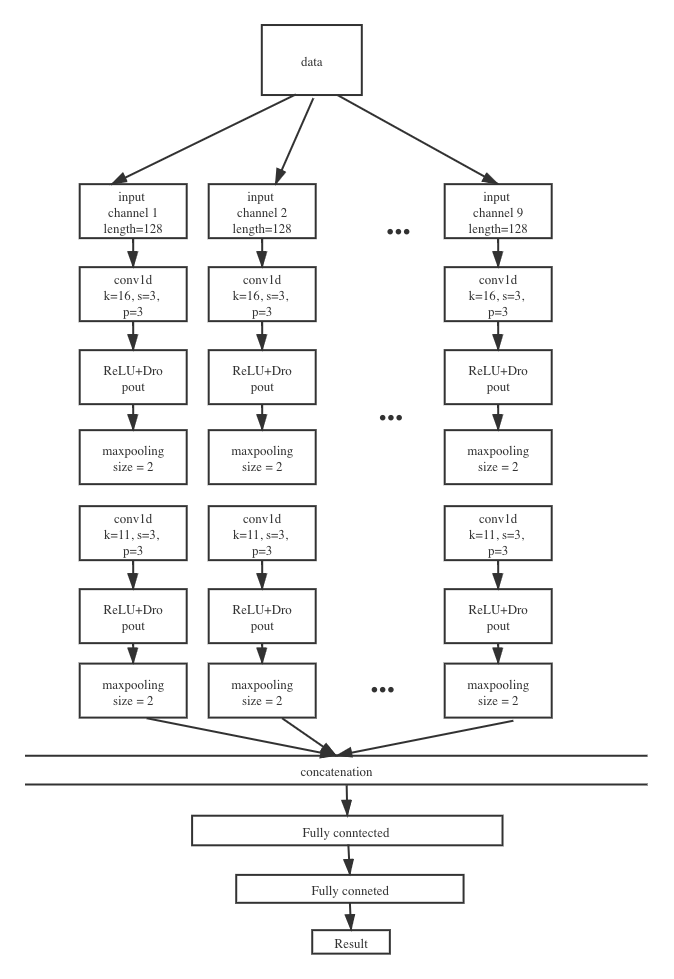

In this project, I adopt similar neural network architecture of *[1] Yi Zheng, Qi Liu, Enhong Chen, Yong Ge, J. Leon Zhao, Time Series Classification Using Multi-Channels Deep Convolutional Neural Networks, IJCAI 2015*<br> 

I feed each channel of data into a seperate 1d convolutional neural network, try to extract important features automatically then concatenate each result together, feed the result into 3 layer fully connected neural network. The intuition of designing this architecture is to firstly exact features in each channel seperately, then use the features in each channel to classify the exact class.



In [101]:
class Surface_Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()
        
        self.conv1d_channel_0 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
           
        
        )
            
            
        
        self.conv1d_channel_1 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
            
        )
        
        self.conv1d_channel_2 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
           
        )
        
        self.conv1d_channel_3 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
           
        )
        
        self.conv1d_channel_4 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
        )
            
            
        
        self.conv1d_channel_5 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
        )
        
        self.conv1d_channel_6 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
        )
        
        self.conv1d_channel_7 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
            
        )
            

       
        
        self.conv1d_channel_8 = nn.Sequential(
            nn.Conv1d(1, 8, 16, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(8, 16, 11, 3, 3),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.MaxPool1d(kernel_size=2),
            
           
        )

            

        self.dense = nn.Sequential(
            nn.Linear(432, 144),  nn.ReLU(),nn.Dropout(),
            nn.Linear(144, 64),  nn.ReLU(),nn.Dropout(),
            nn.Linear(64, no),  nn.ReLU()
        )
        
            

    def forward(self, t_channel_0, t_channel_1, t_channel_2, t_channel_3, t_channel_4, t_channel_5, t_channel_6, t_channel_7, t_channel_8):
        conv1d_out_channel_0 = self.conv1d_channel_0(t_channel_0)
        conv1d_out_channel_1 = self.conv1d_channel_1(t_channel_1)
        conv1d_out_channel_2 = self.conv1d_channel_2(t_channel_2)
        conv1d_out_channel_3 = self.conv1d_channel_3(t_channel_3)
        conv1d_out_channel_4 = self.conv1d_channel_4(t_channel_4)
        conv1d_out_channel_5 = self.conv1d_channel_5(t_channel_5)
        conv1d_out_channel_6 = self.conv1d_channel_6(t_channel_6)
        conv1d_out_channel_7 = self.conv1d_channel_7(t_channel_7)
        conv1d_out_channel_8 = self.conv1d_channel_8(t_channel_8)
        
        t_in = torch.cat([conv1d_out_channel_0,conv1d_out_channel_1, conv1d_out_channel_2, conv1d_out_channel_3, conv1d_out_channel_4, conv1d_out_channel_5, conv1d_out_channel_6, conv1d_out_channel_7, conv1d_out_channel_8], dim=1)
        res = t_in.view(t_in.size(0), -1)
        out = self.dense(res)
        return out
        

<font size="5">**Initial setup for random seed and project path**</font><br>

In [102]:
# set up the seed
seed = 1
np.random.seed(seed)

# path to sample submission
sample = Path.cwd().parent/'input'/'career-con-2019'/'sample_submission.csv'
ROOT = Path.cwd().parent/'input'/'career-con-2019-preprocessed-data'

raw_arr = raw_array.transpose(0,2,1)
target = target_array

raw_dim_data = [None]*9
for i in range(0, 9):
    raw_dim_data[i] = raw_arr[:,i,:]    
    raw_dim_data[i] = raw_dim_data[i].reshape([3810,1,128])


trn_sz = 3810  
datasets = create_datasets((raw_dim_data), trn_sz, seed=seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trn_dl, val_dl, tst_dl, new_tst_dl = create_loaders(datasets, bs=256)

<font size="5">**Training model**</font><br>
Now we are going to feed data into the neural network.
I set hyperparameter learning_rate = 0.002, max_epochs=10000, max_waiting_epoch=100

In [103]:
raw_feat = raw_arr.shape[1]


learning_rate = 0.002
max_epochs = 10000
iterations_per_epoch = len(trn_dl)
num_classes = 9
best_acc = 0
max_waiting_epoch, trials = 100, 0
step = 2
loss_history = []
acc_history = []

model = Surface_Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=learning_rate)

print('Start model training')

for epoch in range(0, max_epochs):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_channel_0, x_channel_1,  x_channel_2,  x_channel_3,  x_channel_4,  x_channel_5,  x_channel_6,  x_channel_7,  x_channel_8, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_channel_0, x_channel_1, x_channel_2, x_channel_3, x_channel_4, x_channel_5, x_channel_6, x_channel_7, x_channel_8)
        
    
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    
    for batch in val_dl:
        x_channel_0, x_channel_1,  x_channel_2,  x_channel_3,  x_channel_4,  x_channel_5,  x_channel_6,  x_channel_7,  x_channel_8, y_batch = [t.to(device) for t in batch]
        
        out = model(x_channel_0, x_channel_1, x_channel_2, x_channel_3, x_channel_4, x_channel_5, x_channel_6, x_channel_7, x_channel_8)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')

    
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= max_waiting_epoch:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   0. Loss: 1.3078. Acc.: 36.48%
Epoch 0 best model saved with accuracy: 36.48%
Epoch:   1. Loss: 1.2422. Acc.: 38.32%
Epoch 1 best model saved with accuracy: 38.32%
Epoch:   2. Loss: 1.2044. Acc.: 38.71%
Epoch 2 best model saved with accuracy: 38.71%
Epoch:   3. Loss: 1.1563. Acc.: 39.76%
Epoch 3 best model saved with accuracy: 39.76%
Epoch:   4. Loss: 1.1221. Acc.: 41.08%
Epoch 4 best model saved with accuracy: 41.08%
Epoch:   5. Loss: 1.0981. Acc.: 41.21%
Epoch 5 best model saved with accuracy: 41.21%
Epoch:   6. Loss: 1.0704. Acc.: 41.60%
Epoch 6 best model saved with accuracy: 41.60%
Epoch:   7. Loss: 1.0448. Acc.: 41.99%
Epoch 7 best model saved with accuracy: 41.99%
Epoch:   8. Loss: 1.0384. Acc.: 43.31%
Epoch 8 best model saved with accuracy: 43.31%
Epoch:   9. Loss: 1.0245. Acc.: 42.39%
Epoch:  10. Loss: 1.0242. Acc.: 41.73%
Epoch:  11. Loss: 0.9966. Acc.: 42.39%
Epoch:  12. Loss: 0.9953. Acc.: 48.43%
Epoch 12 best model saved with accuracy: 48.43%
E

KeyboardInterrupt: 

<font size="5">**Performance on new testing data**</font><br>
The result of cross-validation is around 0.8


In [ ]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()

for batch in new_tst_dl:
    
        x_channel_0, x_channel_1,  x_channel_2,  x_channel_3,  x_channel_4,  x_channel_5,  x_channel_6,  x_channel_7,  x_channel_8, y_batch = [t.to(device) for t in batch]
        out = model(x_channel_0, x_channel_1, x_channel_2, x_channel_3, x_channel_4, x_channel_5, x_channel_6, x_channel_7, x_channel_8)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
acc = correct / total
print("accurancy on 20 new test data: "+str(acc))

<font size="5">**Cross-validation on testing data**</font><br>

The result of cross-validation is around 0.8.

In [ ]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()

for batch in tst_dl:
    
        x_channel_0, x_channel_1,  x_channel_2,  x_channel_3,  x_channel_4,  x_channel_5,  x_channel_6,  x_channel_7,  x_channel_8, y_batch = [t.to(device) for t in batch]
        out = model(x_channel_0, x_channel_1, x_channel_2, x_channel_3, x_channel_4, x_channel_5, x_channel_6, x_channel_7, x_channel_8)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
acc = correct / total
print("accurancy on test data: "+str(acc))

<font size="5">**Experience I learned from this project**</font><br>
1. When trainging neural networks, deeper achitecture doesn't mean better performance. 
2. Find appropriate kernel size is important. Too big or too small kernels are difficult for neural networks to capture features.
3. When we train deep neural networks, if we choose softmax as activation function, it's easy to get gradient vanishing problems. Changing to ReLU is a good option.